# This task relates to geospatial analysis for election purposes

## The objective for this task includes:
#### 1. Providing an overview of the official election results
#### 2. Geocodimg individual polling unit with their longitude and latitude data
#### 3. Clustering polling units together based on their geocodes
#### 4. Identifying outlier polling units. 
#### 5. Identifying polling units with anomalous voting patterns (areas of over-voting or voter suppression).
#### 6. Making recommendations for future elections

In [64]:
import pandas as pd
import numpy as np
from opencage.geocoder import OpenCageGeocode #Geocoding
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv('OSUN_crosschecked.csv')

In [28]:
pd.set_option ("display.max_columns", None)
df.head()

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,False,False,False,UNKNOWN,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",245,881,True,-1,False,False,False,False,UNKNOWN,40,11,175,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
2,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-004,"METHODIST PRY. SCHOOL, AYETORO",117,308,True,-1,False,False,False,False,UNKNOWN,14,3,99,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
3,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-007,OPEN SPACE ODO-IWARA,187,538,True,-1,False,False,False,False,UNKNOWN,25,4,155,0,https://docs.inecelectionresults.net/elections...
4,OSUN,ATAKUMOSA EAST,IGANGAN,29-01-02-001,"N.U.D PRY. SCHOL, IGANGAN",187,558,True,-1,False,False,False,False,UNKNOWN,22,0,161,0,https://docs.inecelectionresults.net/elections...


In [29]:
# check for null values
df.isnull().any()

State                     False
LGA                       False
Ward                      False
PU-Code                   False
PU-Name                   False
Accredited_Voters         False
Registered_Voters         False
Results_Found             False
Transcription_Count       False
Result_Sheet_Stamped      False
Result_Sheet_Corrected    False
Result_Sheet_Invalid      False
Result_Sheet_Unclear      False
Result_Sheet_Unsigned     False
APC                       False
LP                        False
PDP                       False
NNPP                      False
Results_File              False
dtype: bool

## Perform the Geocoding.

In [30]:
# To do this, I first merge the LG, state, ward, and PU address to one column called address to give the fill address of each polling unit.
# This new column is what will be used for the geocoding

df['Address'] = df[['PU-Name', 'Ward', 'LGA', 'State']].astype(str).agg(' '.join, axis=1) + ' Nigeria'
df1 =df[['Address']]
df1

,Address
0,TOWN HALL IWARA IWARA ATAKUMOSA EAST OSUN Nigeria
1,"L.A. SCHOOL, IWIKUN IWARA ATAKUMOSA EAST OSUN ..."
2,"METHODIST PRY. SCHOOL, AYETORO IWARA ATAKUMOSA..."
3,OPEN SPACE ODO-IWARA IWARA ATAKUMOSA EAST OSUN...
4,"N.U.D PRY. SCHOL, IGANGAN IGANGAN ATAKUMOSA EA..."
...,...
2243,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK..."
2244,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK..."
2245,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS..."
2246,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS..."


### Only the first 2004 rows were geocoded the first day due to limits on Opencage free account

In [31]:

# Initialize OpenCage Geocoder with your API key
API_KEY = '35155c1fb35f4bc7901f05a976ebe826' # My real API key was altered a bit for confidentiality purposes
geocoder = OpenCageGeocode(API_KEY)

# Function to get coordinates
def get_coordinates(address):
    try:
        result = geocoder.geocode(address)
        if result:
            return pd.Series([result[0]['geometry']['lat'], result[0]['geometry']['lng']])
        else:
            return pd.Series([None, None])  # Return None if no location found
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return pd.Series([None, None])


# Apply geocoding function to each address
df[['Latitude', 'Longitude']] = df['Address'].apply(get_coordinates)

# Save geocoded data
df.to_csv('geocoded_address.csv', index=False)

print(df.head())  # Print first few rows to verify

  State             LGA     Ward       PU-Code  \
0  OSUN  ATAKUMOSA EAST    IWARA  29-01-01-001   
1  OSUN  ATAKUMOSA EAST    IWARA  29-01-01-003   
2  OSUN  ATAKUMOSA EAST    IWARA  29-01-01-004   
3  OSUN  ATAKUMOSA EAST    IWARA  29-01-01-007   
4  OSUN  ATAKUMOSA EAST  IGANGAN  29-01-02-001   

                          PU-Name  Accredited_Voters  Registered_Voters  \
0                 TOWN HALL IWARA                181                942   
1             L.A. SCHOOL, IWIKUN                245                881   
2  METHODIST PRY. SCHOOL, AYETORO                117                308   
3            OPEN SPACE ODO-IWARA                187                538   
4       N.U.D PRY. SCHOL, IGANGAN                187                558   

   Results_Found  Transcription_Count  Result_Sheet_Stamped  \
0           True                   -1                 False   
1           True                   -1                 False   
2           True                   -1                 False

### The geocoding of the remaining rows will be completed subsequently
### This is the second day completion of the geocoding of the pollin units

In [32]:
# Initialize OpenCage Geocoder with your API key
API_KEY = '35155c1fb35f4bc7901f05a976ebe826'
geocoder = OpenCageGeocode(API_KEY)

# First extract the remaining location which needs to be geocoded
First_geocode = pd.read_csv('geocoded_address.csv')
df_gc= First_geocode.loc[2000:]
df_gc


# Function to get coordinates
def get_coordinates(address):
    try:
        result = geocoder.geocode(address)
        if result:
            return pd.Series([result[0]['geometry']['lat'], result[0]['geometry']['lng']])
        else:
            return pd.Series([None, None])  # Return None if no location found
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return pd.Series([None, None])


# Apply geocoding function to each address
df_gc[['Latitude', 'Longitude']] = df_gc['Address'].apply(get_coordinates)

# Save geocoded data
df_gc.to_csv('geocoded_address_new.csv', index=False)

print(df_gc.head())  # Print first few rows to verify


     State    LGA               Ward       PU-Code                 PU-Name  \
2000  OSUN  OROLU   OLUFON OROLU 'H'  29-29-08-005  IDI IROKO/ABEPE KAJOLA   
2001  OSUN  OROLU   OLUFON OROLU 'H'  29-29-08-006         ISANGBE/ELEGUDU   
2002  OSUN  OROLU  OLUFON OROLU  'I'  29-29-09-003      GBOGBO PRY. SCHOOL   
2003  OSUN  OROLU  OLUFON OROLU  'I'  29-29-09-007          ALAIKO VILLAGE   
2004  OSUN  OROLU  OLUFON OROLU  'I'  29-29-09-008          AROHUN VILLAGE   

      Accredited_Voters  Registered_Voters  Results_Found  \
2000                125                280           True   
2001                182                345           True   
2002                110                219           True   
2003                 79                140           True   
2004                167                348           True   

      Transcription_Count  Result_Sheet_Stamped  Result_Sheet_Corrected  \
2000                   -1                 False                    True   
2001          

C:\Users\DELL\AppData\Local\Temp\ipykernel_9768\122790089.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gc[['Latitude', 'Longitude']] = df_gc['Address'].apply(get_coordinates)


## Now let us merge the results of both geocoding operations into a single geocoded file

In [49]:
df = pd.read_csv('geocoded_address_new.csv')
df1 = pd.read_csv('geocoded_address.csv')
Geocoded_combined = pd.concat([df1.iloc[:2000], df])
Geocoded_combined.reset_index(drop = True)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File,Address,Latitude,Longitude
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,False,False,False,UNKNOWN,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,TOWN HALL IWARA IWARA ATAKUMOSA EAST OSUN Nigeria,7.5,4.5
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",245,881,True,-1,False,False,False,False,UNKNOWN,40,11,175,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,"L.A. SCHOOL, IWIKUN IWARA ATAKUMOSA EAST OSUN ...",7.5,4.5
2,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-004,"METHODIST PRY. SCHOOL, AYETORO",117,308,True,-1,False,False,False,False,UNKNOWN,14,3,99,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,"METHODIST PRY. SCHOOL, AYETORO IWARA ATAKUMOSA...",7.5,4.5
3,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-007,OPEN SPACE ODO-IWARA,187,538,True,-1,False,False,False,False,UNKNOWN,25,4,155,0,https://docs.inecelectionresults.net/elections...,OPEN SPACE ODO-IWARA IWARA ATAKUMOSA EAST OSUN...,7.5,4.5
4,OSUN,ATAKUMOSA EAST,IGANGAN,29-01-02-001,"N.U.D PRY. SCHOL, IGANGAN",187,558,True,-1,False,False,False,False,UNKNOWN,22,0,161,0,https://docs.inecelectionresults.net/elections...,"N.U.D PRY. SCHOL, IGANGAN IGANGAN ATAKUMOSA EA...",7.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,OSUN,OSOGBO,ATAOJA 'E',29-30-05-042,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,False,False,False,UNKNOWN,25,4,14,2,https://docs.inecelectionresults.net/elections...,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",NaN,NaN
2244,OSUN,OSOGBO,ATAOJA 'E',29-30-11-019,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",157,546,True,-1,False,False,False,False,UNKNOWN,65,19,56,0,https://docs.inecelectionresults.net/elections...,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",NaN,NaN
2245,OSUN,OSOGBO,BABA KEKERE,29-30-14-019,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS...",139,179,True,-1,False,False,False,False,UNKNOWN,46,4,50,1,https://docs.inecelectionresults.net/elections...,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS...",NaN,NaN
2246,OSUN,OSOGBO,BABA KEKERE,29-30-14-020,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS...",139,179,True,-1,False,True,False,False,UNKNOWN,25,5,44,1,https://docs.inecelectionresults.net/elections...,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS...",NaN,NaN


In [34]:
# lets now clean the data containing the geocoded coordinates of the PUs by filling the few unfound coordinates forward
# Geocoded_combined.duplicated()
Geocoded_combined.isnull().sum()

State                       0
LGA                         0
Ward                        0
PU-Code                     0
PU-Name                     0
Accredited_Voters           0
Registered_Voters           0
Results_Found               0
Transcription_Count         0
Result_Sheet_Stamped        0
Result_Sheet_Corrected      0
Result_Sheet_Invalid        0
Result_Sheet_Unclear        0
Result_Sheet_Unsigned       0
APC                         0
LP                          0
PDP                         0
NNPP                        0
Results_File                0
Address                     0
Latitude                  131
Longitude                 131
dtype: int64

In [35]:
Geocoded_combined[['Latitude', 'Longitude']] = Geocoded_combined[['Latitude', 'Longitude']].fillna(method = 'ffill')

C:\Users\DELL\AppData\Local\Temp\ipykernel_9768\1596874865.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Geocoded_combined[['Latitude', 'Longitude']] = Geocoded_combined[['Latitude', 'Longitude']].fillna(method = 'ffill')


In [36]:
Geocoded_combined.isnull().sum()
Geocoded_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2248 entries, 0 to 247
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2248 non-null   object 
 1   LGA                     2248 non-null   object 
 2   Ward                    2248 non-null   object 
 3   PU-Code                 2248 non-null   object 
 4   PU-Name                 2248 non-null   object 
 5   Accredited_Voters       2248 non-null   int64  
 6   Registered_Voters       2248 non-null   int64  
 7   Results_Found           2248 non-null   bool   
 8   Transcription_Count     2248 non-null   int64  
 9   Result_Sheet_Stamped    2248 non-null   bool   
 10  Result_Sheet_Corrected  2248 non-null   bool   
 11  Result_Sheet_Invalid    2248 non-null   bool   
 12  Result_Sheet_Unclear    2248 non-null   bool   
 13  Result_Sheet_Unsigned   2248 non-null   object 
 14  APC                     2248 non-null   int64 

## Saving the file updated with the coordinates back to the data file

### Now, save the entire election results data sheet|

In [50]:
Geocoded_combined.to_csv('OSUN_Geocoded_updated.csv', index = False)

# Clustering Analysis sing HDBSCAN

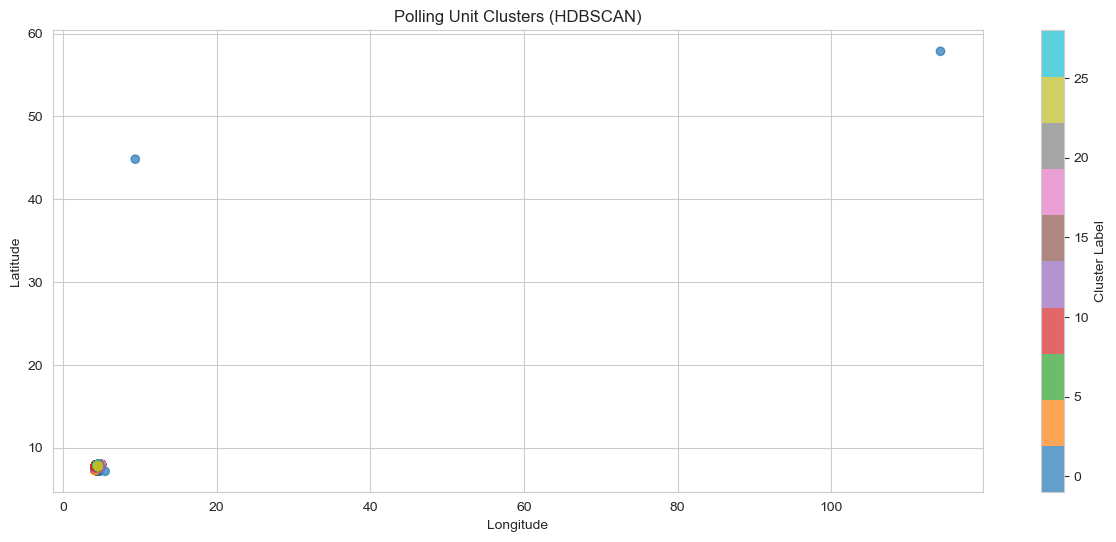

  State             LGA   Ward       PU-Code  \
0  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-001   
1  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-003   
2  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-004   
3  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-007   
4  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-009   

                                             PU-Name  Accredited_Voters  \
0                                    TOWN HALL IWARA                181   
1                                L.A. SCHOOL, IWIKUN                245   
2                     METHODIST PRY. SCHOOL, AYETORO                117   
3                               OPEN SPACE ODO-IWARA                187   
4  OPEN SPACE INFRONT OF OSUN STATE GOVT. REVENUE...                 52   

   Registered_Voters  Results_Found  Transcription_Count  \
0                942           True                   -1   
1                881           True                   -1   
2                308           True                   -1   
3                538

30

In [53]:

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from geopy.distance import great_circle


# Read the updated file and save it as a dataframe again
df = pd.read_csv('OSUN_Geocoded_updated.csv')
# Convert to numpy array for clustering
coords = df[['Latitude', 'Longitude']].to_numpy()


# HDBSCAN Clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=10, metric='haversine')
df['HDBSCAN_Cluster'] = hdb.fit_predict(np.radians(coords))

# Plot results
plt.figure(figsize=(15, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['HDBSCAN_Cluster'], cmap='tab10', alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Polling Unit Clusters (HDBSCAN)")
plt.colorbar(label="Cluster Label")
plt.show()

# Save results
df.to_csv('OSUN_Geocoded_Clustered.csv', index=False)

print(df.head())  # Show first few rows
df['HDBSCAN_Cluster'].nunique()

In [52]:
df.to_csv('OSUN_Geocoded_Clustered.csv', index=False)

In [40]:
df['HDBSCAN_Cluster'].nunique()

30

# Clustering Analysis using DBSCAN

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from geopy.distance import great_circle

df2 = pd.read_csv('OSUN_Geocoded_updated.csv')
# Convert to numpy array for clustering
coords = df2[['Latitude', 'Longitude']].to_numpy()

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.01, min_samples=5, metric='haversine')  # Adjust eps as needed
df2['DBSCAN_Cluster'] = dbscan.fit_predict(np.radians(coords))  # Convert to radians for geospatial distance

# Plot results
plt.figure(figsize=(15, 6))
plt.scatter(df2['Longitude'], df2['Latitude'], c=df2['DBSCAN_Cluster'], cmap='tab10', alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Polling Unit Clusters (DBSCAN)")
plt.colorbar(label="Cluster Label")
plt.show()

# Save results
df2.to_csv('clustered_dbscan_polling_units.csv', index=False)

df2['DBSCAN_Cluster'].nunique() # Show how many clusters were obtained


### The dbscan clustering gave just 2 clusters due to the radius used, it is not robust enough for this data and is therefore jettisoned

# Spatial Outlier Analysis

### Local Moran’s I to identify localized spatial autocorrelation.

C:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 28 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


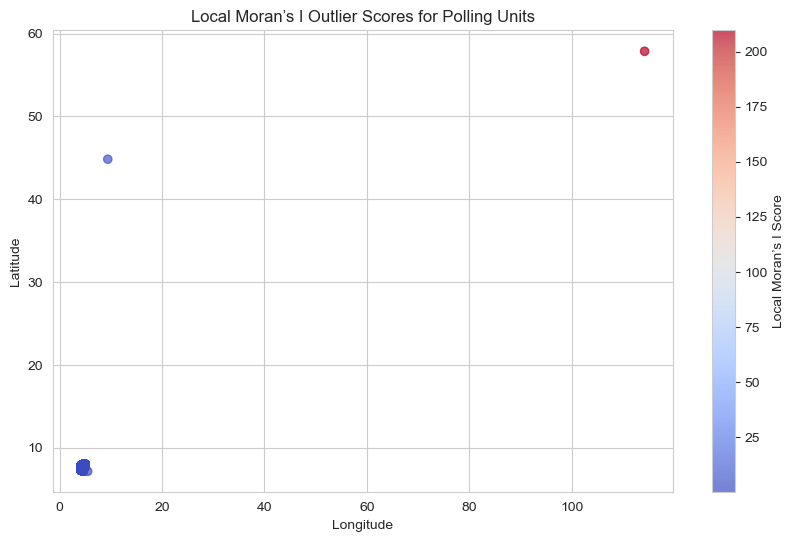

   Latitude  Longitude  Local_Moran_I  p_value     Cluster_Type
0       7.5        4.5       0.024315    0.062  Not Significant
1       7.5        4.5       0.024315    0.062  Not Significant
2       7.5        4.5       0.024315    0.062  Not Significant
3       7.5        4.5       0.024315    0.062  Not Significant
4       7.5        4.5       0.024315    0.062  Not Significant


In [55]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import KNN, Rook, Queen
from esda.moran import Moran_Local
from shapely.geometry import Point

# Load polling unit dataset (ensure it has 'Latitude' and 'Longitude' columns)
df = pd.read_csv('OSUN_Geocoded_Clustered.csv')

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # WGS 84 coordinate system

# Create spatial weights (using k-Nearest Neighbors with k=5)
knn_weights = KNN.from_dataframe(gdf, k=5)

# Compute Local Moran's I
moran_local = Moran_Local(gdf['Latitude'], knn_weights)

# Store the outlier scores (z-scores of Local Moran’s I)
gdf['Local_Moran_I'] = moran_local.Is
gdf['p_value'] = moran_local.p_sim  # P-value for significance testing
gdf['Cluster_Type'] = np.where(
    (moran_local.q == 1) & (moran_local.p_sim < 0.05), 'High-High',
    np.where((moran_local.q == 2) & (moran_local.p_sim < 0.05), 'Low-Low',
             np.where((moran_local.q == 3) & (moran_local.p_sim < 0.05), 'High-Low',
                      np.where((moran_local.q == 4) & (moran_local.p_sim < 0.05), 'Low-High', 'Not Significant'))))

# Save results to CSV
gdf.to_csv('OSUN_Geocoded_Clustered_local_moran.csv', index=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(gdf['Longitude'], gdf['Latitude'], c=gdf['Local_Moran_I'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Local Moran’s I Score")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Local Moran’s I Outlier Scores for Polling Units")
plt.show()

# Display first few rows
print(gdf[['Latitude', 'Longitude', 'Local_Moran_I', 'p_value', 'Cluster_Type']].head())

C:\Users\DELL\AppData\Local\Temp\ipykernel_9768\1494243327.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=gdf["Cluster_Type"], order=gdf["Cluster_Type"].value_counts().index, palette="viridis")


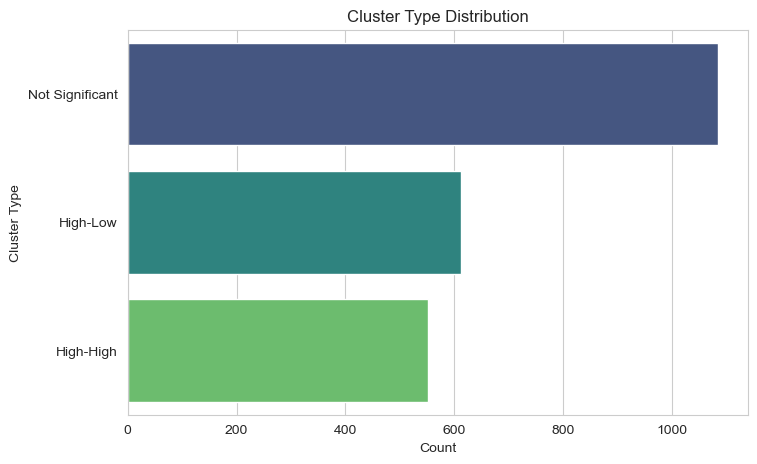

In [66]:
## Plot the distribution of the Local_Moran's spatial autocoreelation as a bar chart
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.countplot(y=gdf["Cluster_Type"], order=gdf["Cluster_Type"].value_counts().index, palette="viridis")

# Customize the plot
plt.title("Cluster Type Distribution")
plt.xlabel("Count")
plt.ylabel("Cluster Type")

# Show the plot
plt.show()


In [62]:
#  Tab_summary = pd.DataFrame((gdf['Cluster_Type'].value_counts()), columns = [['Cluster Type', 'Frequency']])
Tab =  (gdf['Cluster_Type'].value_counts())
Tab

Cluster_Type
Not Significant    1084
High-Low            612
High-High           552
Name: count, dtype: int64

## Getis-Ord Gi(Hot Spot Analysis) to detect significant vote concentration.

C:\Users\DELL\AppData\Local\Temp\ipykernel_9768\639970469.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf["Accredited_Voters"].fillna(gdf["Accredited_Voters"].mean(), inplace=True)
C:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 28 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


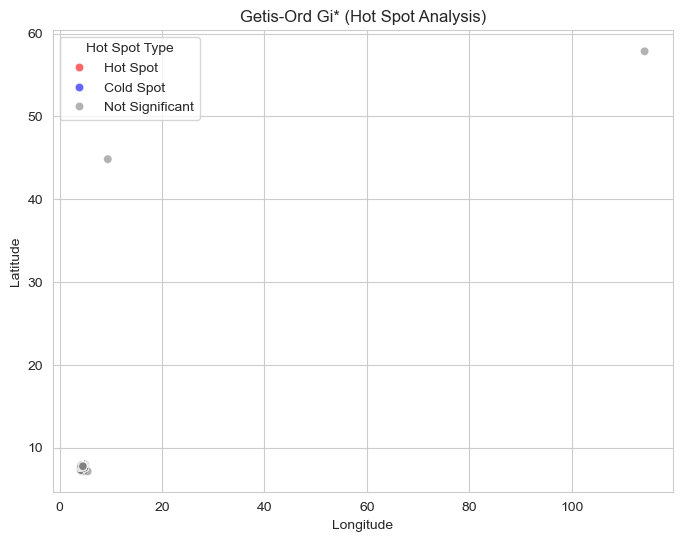

In [69]:
import libpysal as ps
import esda
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (Ensure your dataset has latitude & longitude)
df = pd.read_csv("OSUN_Geocoded_Clustered_local_moran.csv")

# Convert to GeoDataFrame
geometry = gpd.points_from_xy(df["Longitude"], df["Latitude"])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Ensure the "Accredited_Voters" column is float64
gdf["Accredited_Voters"] = gdf["Accredited_Voters"].astype(float)

# Handle missing values by filling them with the column mean
gdf["Accredited_Voters"].fillna(gdf["Accredited_Voters"].mean(), inplace=True)

# Define spatial weights using K-Nearest Neighbors (KNN)
w = ps.weights.KNN.from_dataframe(gdf, k=5)  # Adjust k to reduce disconnected components
w.transform = "R"  # Row standardization

# Compute Getis-Ord Gi* statistic
g_star = esda.getisord.G_Local(gdf["Accredited_Voters"], w)

# Add Gi* values and p-values to the DataFrame
gdf["Gi_star"] = g_star.Zs  # Standardized Getis-Ord Gi*
gdf["p_value"] = g_star.p_sim  # P-values for significance

# Identify significant hot/cold spots
gdf["Hotspot_Type"] = "Not Significant"
gdf.loc[(gdf["Gi_star"] > 1.96) & (gdf["p_value"] < 0.05), "Hotspot_Type"] = "Hot Spot"
gdf.loc[(gdf["Gi_star"] < -1.96) & (gdf["p_value"] < 0.05), "Hotspot_Type"] = "Cold Spot"

# Plot results
plt.figure(figsize=(8, 6))
palette = {"Hot Spot": "red", "Cold Spot": "blue", "Not Significant": "gray"}
order = ["Hot Spot", "Cold Spot", "Not Significant"]
sns.scatterplot(data=gdf, x="Longitude", y="Latitude", hue="Hotspot_Type", palette=palette, hue_order=order, alpha=0.6)
plt.title("Getis-Ord Gi* (Hot Spot Analysis)")
plt.legend(title="Hot Spot Type")
plt.show()


In [70]:
gdf.to_csv('Vote and location concentration.csv')

In [ ]:
dg = pd.read_csv('Vote and location concentration.csv')

## Votes Anomaly Detection Using Isolation Forest Algorithm

### This is to detect any area of voter suppression or overvoting

In [73]:
from sklearn.ensemble import IsolationForest
import numpy as np

df = pd.read_csv('Vote and location concentration.csv')
# Selecting relevant numerical features for anomaly detection
features = ["Accredited_Voters", "Registered_Voters", "APC", "LP", "PDP", "NNPP", "Latitude", "Longitude"]
data = df[features]

# Handling potential missing values
data = data.fillna(data.median())

# Applying Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df["Anomaly_Score"] = iso_forest.fit_predict(data)

# Mapping anomaly labels (-1: anomaly, 1: normal)
df["Anomaly_Label"] = np.where(df["Anomaly_Score"] == -1, "Anomalous", "Normal")

# Display anomaly summary
df["Anomaly_Label"].value_counts()


Anomaly_Label
Normal       2135
Anomalous     113
Name: count, dtype: int64

In [74]:
df.to_csv('Final Data File.csv', index = False)

In [78]:
# Re-import necessary libraries for mapping
import folium

# Define the map center
map_center = [df["Latitude"].mean(), df["Longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Add data points to the map
for _, row in df.iterrows():
    color = "red" if row["Anomaly_Label"] == "Anomalous" else "blue"
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
    ).add_to(m)

# Save the map
map_path = "/Users/DELL/Desktop/MY APPS/HNG/Stage 8.html"
m.save(map_path)
map_path

'/Users/DELL/Desktop/MY APPS/HNG/Stage 8.html'